# Tilapia Regression Model with SARIMA
By Miguel Andre R. Pajarillo

## Load the Dataset

In [1]:
import pandas as pd

In [2]:
Tilapia_UN = pd.read_csv('./data/potato_UN_potato_UN.csv.csv')

In [3]:
Tilapia_DA = pd.read_csv('./data/potato_DA_potato_DA.csv.csv')

In [4]:
Tilapia_UN

,cm_id,cm_name,um_id,um_name,mp_month,mp_year,mp_price
0,148,Potatoes (Irish) - Retail,5,KG,1,2008,43.50
1,148,Potatoes (Irish) - Retail,5,KG,1,2008,45.36
2,148,Potatoes (Irish) - Retail,5,KG,1,2008,32.44
3,148,Potatoes (Irish) - Retail,5,KG,1,2008,39.51
4,148,Potatoes (Irish) - Retail,5,KG,1,2008,43.88
...,...,...,...,...,...,...,...
2551,148,Potatoes (Irish) - Retail,5,KG,6,2021,51.25
2552,148,Potatoes (Irish) - Retail,5,KG,6,2021,68.13
2553,148,Potatoes (Irish) - Retail,5,KG,6,2021,52.50
2554,148,Potatoes (Irish) - Retail,5,KG,6,2021,60.00


In [5]:
Tilapia_DA.head()

,cm_id,cm_name,um_id,um_name,mp_month,mp_year,mp_price
0,NaN,Potatoes (Irish) - Retail,NaN,KG,1,2022,75.13
1,NaN,Potatoes (Irish) - Retail,NaN,KG,2,2022,68.40
2,NaN,Potatoes (Irish) - Retail,NaN,KG,3,2022,66.16
3,NaN,Potatoes (Irish) - Retail,NaN,KG,4,2022,68.65
4,NaN,Potatoes (Irish) - Retail,NaN,KG,5,2022,71.25


## Extract Necessary Columns (Date and Price)

### UN World Food Programme

In [6]:
Tilapia_UN['date'] = pd.to_datetime(
    Tilapia_UN.rename(columns={'mp_year': 'year', 'mp_month': 'month'})[['year', 'month']].assign(day=15)
)

In [7]:
Tilapia_UN = Tilapia_UN.drop(columns=['cm_id', 'cm_name', 'um_id', 'um_name', 'mp_month', 'mp_year'])

In [8]:
Tilapia_UN.head()

,mp_price,date
0,43.50,2008-01-15
1,45.36,2008-01-15
2,32.44,2008-01-15
3,39.51,2008-01-15
4,43.88,2008-01-15


### DA Bantay Presyo

In [9]:
Tilapia_DA['date'] = pd.to_datetime(
    Tilapia_DA.rename(columns={'mp_year': 'year', 'mp_month': 'month'})[['year', 'month']].assign(day=15)
)

In [10]:
Tilapia_DA = Tilapia_DA.drop(columns=['cm_id', 'cm_name', 'um_id', 'um_name', 'mp_month', 'mp_year'])

In [11]:
Tilapia_DA.head()

,mp_price,date
0,75.13,2022-01-15
1,68.40,2022-02-15
2,66.16,2022-03-15
3,68.65,2022-04-15
4,71.25,2022-05-15


In [12]:
import matplotlib.pyplot as plt

In [13]:
Tilapia = pd.concat([Tilapia_DA, Tilapia_UN])

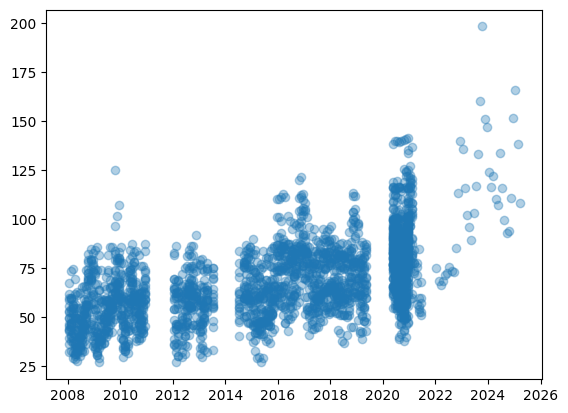

<Figure size 5000x600 with 0 Axes>

In [14]:
plt.scatter(Tilapia['date'], Tilapia['mp_price'], alpha=0.35)
plt.figure(figsize=(50, 6))
plt.show()

In [15]:
from datetime import datetime

In [16]:
# Set Date as the Inex
Tilapia = Tilapia.set_index('date')

In [17]:
# Aggregate samples to mean
Tilapia = Tilapia.resample('MS').mean()

In [18]:
Tilapia['mp_price'] = Tilapia['mp_price'].interpolate(method='linear')

In [19]:
print("🕓 Index Range:")
print(f"Start: {Tilapia.index.min()}")
print(f"End:   {Tilapia.index.max()}")
print(f"Index type: {type(Tilapia.index)}\n")

🕓 Index Range:
Start: 2008-01-01 00:00:00
End:   2025-03-01 00:00:00
Index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>



In [20]:
start_date = datetime(2008,1,1)
end_date = datetime(2026,1,1)
lim_tilapia = Tilapia[start_date:end_date]

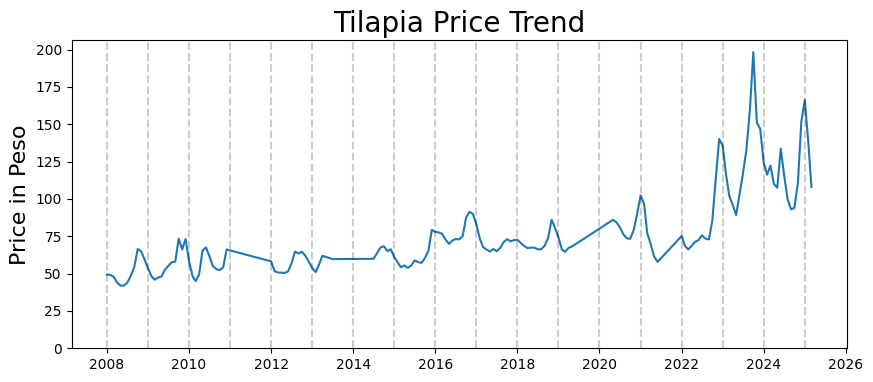

In [21]:
plt.figure(figsize=(10,4))
plt.plot(lim_tilapia)
plt.title('Tilapia Price Trend', fontsize=20)
plt.ylabel('Price in Peso', fontsize=16)
plt.ylim(bottom=0)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

## Remove the trend

In [22]:
first_diff = lim_tilapia.diff()[1:]

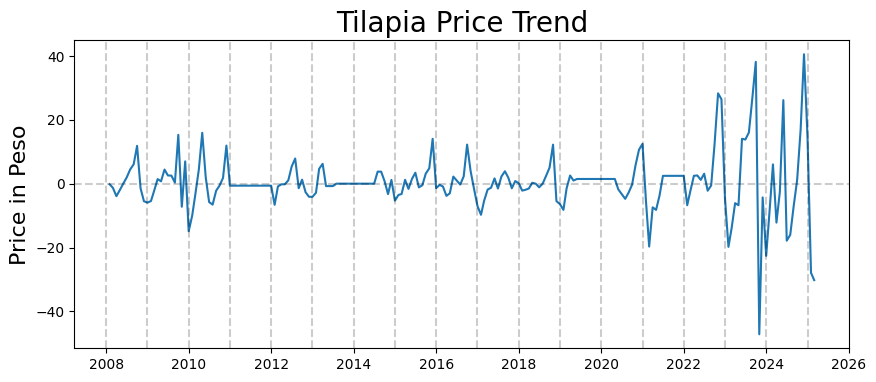

In [23]:
plt.figure(figsize=(10,4))
plt.plot(first_diff)
plt.title('Tilapia Price Trend', fontsize=20)
plt.ylabel('Price in Peso', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)
plt.axhline(0, color='k', linestyle='--', alpha=0.2)

## ACF

In [24]:
from statsmodels.tsa.stattools import acf, pacf

<BarContainer object of 24 artists>

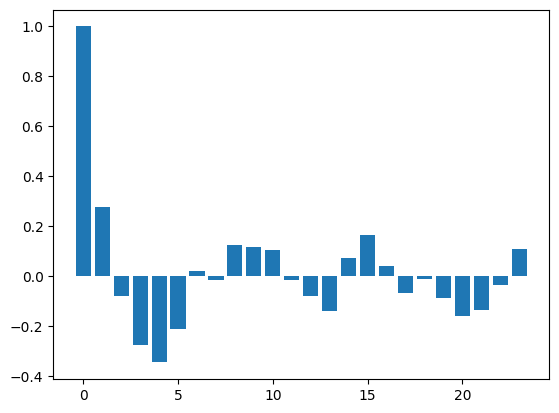

In [30]:
acf_vals = acf(first_diff)
num_lags = 24
plt.bar(range(num_lags), acf_vals[:num_lags])

### Based on ACF, we should start with a seasonal MA process

## PACF

<BarContainer object of 24 artists>

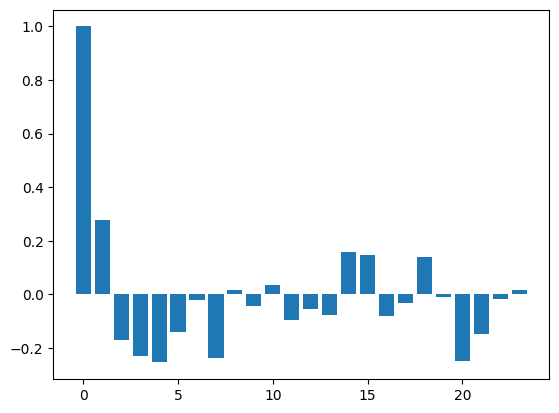

In [31]:
pacf_vals = pacf(first_diff)
num_lags = 24
plt.bar(range(num_lags), pacf_vals[:num_lags])

### Based on PACF, we should start with a seasonal AR process

## Get training and testing sets

In [32]:
from datetime import timedelta

In [33]:
train_end = datetime(2024,9,1)
test_end = datetime(2025,3,1)

train_data = lim_tilapia[:train_end]
test_data = lim_tilapia[train_end + timedelta(days=1):test_end]

In [34]:
Tilapia.describe()

,mp_price
count,207.000000
mean,73.515965
std,24.649446
min,41.951176
25%,59.737586
50%,66.458824
75%,77.102993
max,198.370000


## Fit the SARIMA Model

In [35]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [36]:
my_order = (0,1,0)
my_seasonal_order = (1, 0, 1, 12)
# define model
model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)

In [37]:
from time import time

In [38]:
#fit the model
start = time()
model_fit = model.fit()
end = time()
print('Model Fitting Time:', end - start)

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.50983D+00    |proj g|=  6.40988D-02

At iterate    5    f=  3.50586D+00    |proj g|=  1.86465D-02

At iterate   10    f=  3.50542D+00    |proj g|=  2.63810D-03

At iterate   15    f=  3.50085D+00    |proj g|=  1.51255D-03

At iterate   20    f=  3.50082D+00    |proj g|=  1.61440D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     21     27      1     0     0   1.555D-06   3.501D+00
  F =   3.5008236522499767     

CONVERG

In [39]:
#summary of the model
print(model_fit.summary())

                                      SARIMAX Results                                       
Dep. Variable:                             mp_price   No. Observations:                  201
Model:             SARIMAX(0, 1, 0)x(1, 0, [1], 12)   Log Likelihood                -703.666
Date:                              Tue, 20 May 2025   AIC                           1413.331
Time:                                      15:47:10   BIC                           1423.226
Sample:                                  01-01-2008   HQIC                          1417.335
                                       - 09-01-2024                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.7962      0.633     -1.258      0.208      -2.037       0.444
ma.S.L12       0.70

In [40]:
print(type(test_data))
print(test_data.columns)
print(test_data.head())

<class 'pandas.core.frame.DataFrame'>
Index(['mp_price'], dtype='object')
            mp_price
date                
2024-10-01     94.04
2024-11-01    110.99
2024-12-01    151.56
2025-01-01    166.14
2025-02-01    138.22


In [41]:
# Assuming test_data is a DataFrame with a single column named "mp_price"
test_series = test_data['mp_price']

In [42]:
#get the predictions and residuals
predictions = model_fit.forecast(len(test_data))
predictions = pd.Series(predictions, index=test_data.index)
residuals = test_series - predictions

In [43]:
predictions

date
2024-10-01     90.287016
2024-11-01     96.540473
2024-12-01     98.604678
2025-01-01    100.426020
2025-02-01     99.805997
2025-03-01     97.789841
Freq: MS, Name: predicted_mean, dtype: float64

In [44]:
residuals

date
2024-10-01     3.752984
2024-11-01    14.449527
2024-12-01    52.955322
2025-01-01    65.713980
2025-02-01    38.414003
2025-03-01    10.220159
Freq: MS, dtype: float64

Text(0, 0.5, 'Error')

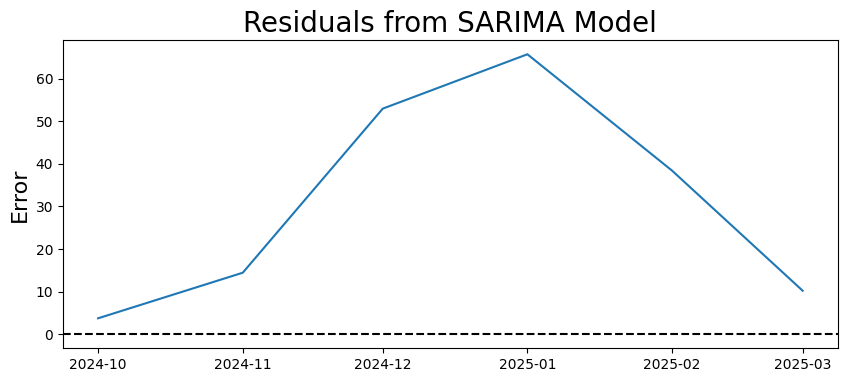

In [45]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

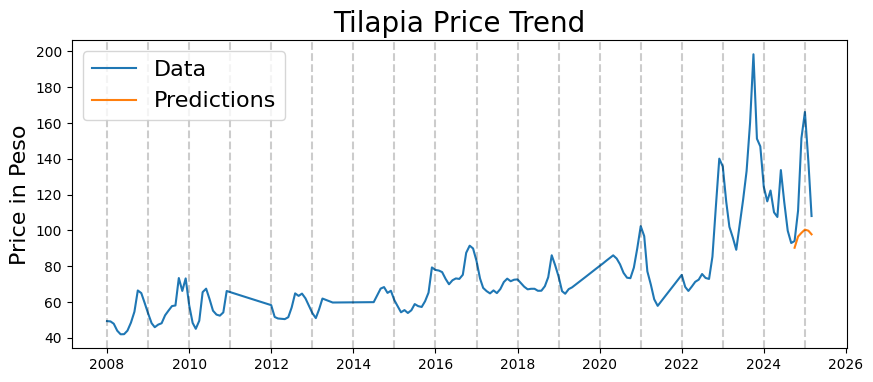

In [46]:
plt.figure(figsize=(10,4))

plt.plot(lim_tilapia)
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Tilapia Price Trend', fontsize=20)
plt.ylabel('Price in Peso', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

## Using the Rolling Forecast Origin

In [47]:
rolling_predictions = test_series.copy()
for train_end in test_series.index:
    train_data = lim_tilapia[:train_end-timedelta(days=1)]
    model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)
    model_fit = model.fit()

    pred = model_fit.forecast()
    rolling_predictions[train_end] = pred

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.50983D+00    |proj g|=  6.40988D-02

At iterate    5    f=  3.50586D+00    |proj g|=  1.86465D-02

At iterate   10    f=  3.50542D+00    |proj g|=  2.63810D-03


 This problem is unconstrained.



At iterate   15    f=  3.50085D+00    |proj g|=  1.51255D-03

At iterate   20    f=  3.50082D+00    |proj g|=  1.61440D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     21     27      1     0     0   1.555D-06   3.501D+00
  F =   3.5008236522499767     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.50612D+00    |proj g|=  4.89513D-02

At iterate    5    f=  3.50346D+00    |proj g|=  1.94083D-02

At iter

/tmp/ipykernel_13025/2554385675.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  rolling_predictions[train_end] = pred
 This problem is unconstrained.
/tmp/ipykernel_13025/2554385675.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  rolling_predictions[train_end] = pred



At iterate   15    f=  3.49894D+00    |proj g|=  1.15164D-03

At iterate   20    f=  3.49892D+00    |proj g|=  3.05128D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     21     27      1     0     0   3.494D-06   3.499D+00
  F =   3.4989151164061396     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.51208D+00    |proj g|=  6.35370D-02

At iterate    5    f=  3.50902D+00    |proj g|=  3.29439D-02

At iter

 This problem is unconstrained.
/tmp/ipykernel_13025/2554385675.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  rolling_predictions[train_end] = pred
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.56195D+00    |proj g|=  6.50720D-02

At iterate    5    f=  3.55132D+00    |proj g|=  3.72236D-02

At iterate   10    f=  3.54763D+00    |proj g|=  1.59719D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     13     16      1     0     0   5.004D-07   3.548D+00
  F =   3.5476310568871732     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

/tmp/ipykernel_13025/2554385675.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  rolling_predictions[train_end] = pred
 This problem is unconstrained.
/tmp/ipykernel_13025/2554385675.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  rolling_predictions[train_end] = pred
 This problem is unconstrained.



At iterate   10    f=  3.54957D+00    |proj g|=  7.85616D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     14      1     0     0   4.915D-06   3.550D+00
  F =   3.5495559513976378     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.59268D+00    |proj g|=  1.16445D-01

At iterate    5    f=  3.57362D+00    |proj g|=  2.97491D-02

At iterate   10    f=  3.57108D+00    |proj g|=  5.05933D-05

       

/tmp/ipykernel_13025/2554385675.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  rolling_predictions[train_end] = pred


In [48]:
rolling_residuals = test_series - rolling_predictions

Text(0, 0.5, 'Error')

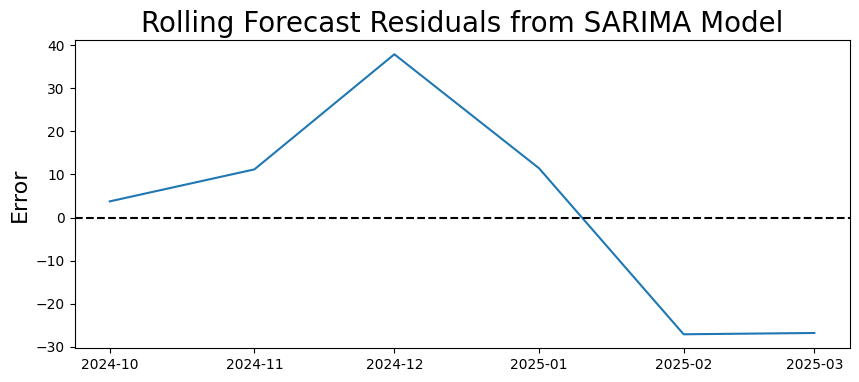

In [49]:
plt.figure(figsize=(10,4))
plt.plot(rolling_residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Rolling Forecast Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

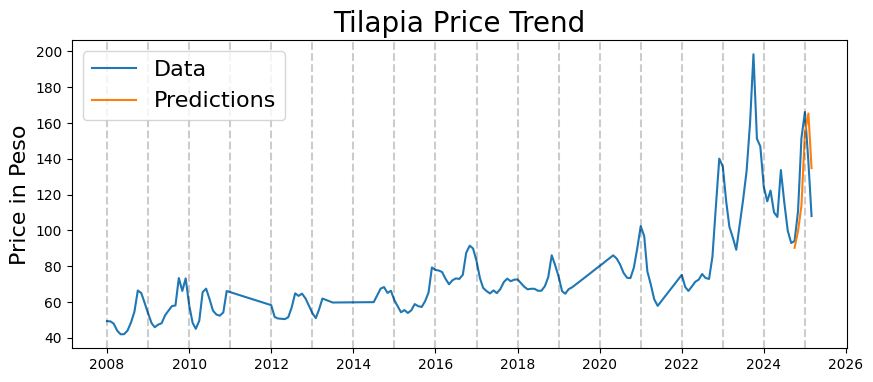

In [50]:
plt.figure(figsize=(10,4))

plt.plot(lim_tilapia)
plt.plot(rolling_predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Tilapia Price Trend', fontsize=20)
plt.ylabel('Price in Peso', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [51]:
import numpy as np

In [52]:
print('Mean Absolute Percent Error:', round(np.mean(abs(rolling_residuals/test_series)),4))

Mean Absolute Percent Error: 0.1505


In [53]:
print('Root Mean Squared Error:', np.sqrt(np.mean(rolling_residuals**2)))

Root Mean Squared Error: 22.930295199281446


## Future Predictions (2025)